In [1]:
import os
import cv2
import torch
from nanodet.util import cfg, load_config, Logger

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

device = torch.device('cuda')

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

In [2]:
config_path = 'demo/nanodet-plus-m_416.yml'
model_path = 'demo/nanodet-plus-m_416_checkpoint.ckpt'
image_path = 'demo/000252.jpg'

load_config(cfg, config_path)
logger = Logger(-1, use_tensorboard=False)

In [3]:
from nanodet.model.arch import build_model
from nanodet.util import Logger, cfg, load_config, load_model_weight
from nanodet.data.transform import Pipeline
from nanodet.data.collate import naive_collate
from nanodet.data.batch_process import stack_batch_img
import numpy as np

class WrapperModel(torch.nn.Module):
    def __init__(self, cfg, model_path, logger, device="cuda:0"):
        super().__init__()

        self.cfg = cfg
        self.device = device
        
        self.num_classes = cfg['model']['arch']['head']['num_classes']
        self.reg_max = cfg['model']['arch']['head']['reg_max']
        model = build_model(cfg.model)
        ckpt = torch.load(model_path, map_location=lambda storage, loc: storage)
        load_model_weight(model, ckpt, logger)
        self.model = model.to(device).eval()

    def forward(self, tensor_img):
        if len(tensor_img.shape) == 4:

            preds = self.model(tensor_img)
            cls_scores = preds.split(
                [self.num_classes, 4 * (self.reg_max + 1)], dim=-1
            )[0]
            
            max_cls_scores = torch.max(cls_scores.sigmoid(), dim=1)[0]
            return max_cls_scores
    
wrapper = WrapperModel(cfg, model_path, logger, device=device)

model size is  1.0x
init weights...
=> loading pretrained model https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth
Finish initialize NanoDet-Plus Head.


In [4]:
img = cv2.imread(image_path)

raw_height = img.shape[0]
raw_width  = img.shape[1]
dst_width, dst_height = cfg.data.val.input_size
ResizeM = np.eye(3)
ResizeM[0, 0] *= dst_width / raw_width
ResizeM[1, 1] *= dst_height / raw_height

# scaling only
numpy_img_warped = cv2.warpPerspective(img, 
                                       ResizeM, 
                                       dsize=tuple(cfg.data.val.input_size), 
                                       flags = cv2.INTER_LINEAR, 
                                       borderMode = cv2.BORDER_CONSTANT)

# normalise
mean, std = cfg.data.val.pipeline["normalize"]
mean = np.array(mean, dtype=np.float32).reshape(1, 1, 3) / 255
std = np.array(std, dtype=np.float32).reshape(1, 1, 3) / 255
numpy_img_normalised = ((numpy_img_warped.astype(np.float32) / 255) - mean) / std

# numpy to pytorch
processed_tensor_img = torch.from_numpy(numpy_img_normalised.transpose(2, 0, 1)).to(device).type(torch.cuda.FloatTensor).unsqueeze(0)

input_   = torch.cat([processed_tensor_img, processed_tensor_img])
print(input_.shape)

torch.Size([2, 3, 416, 416])


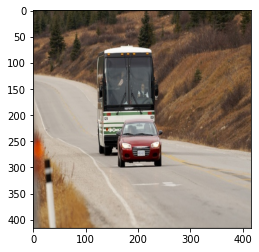

In [17]:
plt.imshow(numpy_img_warped[:,:,::-1])

[matplotlib.image][05-06 10:04:41]WARNING:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


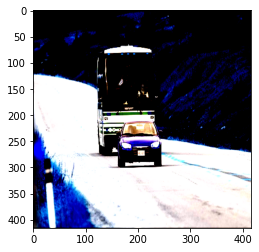

In [6]:
import matplotlib.pyplot as plt

plt.imshow(input_[0].permute(1, 2, 0).cpu().detach().numpy())

[matplotlib.image][05-06 10:11:16]WARNING:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2.622571


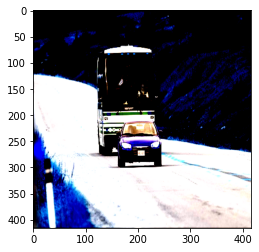

In [10]:
print(np.max(numpy_img_normalised))
plt.imshow(numpy_img_normalised)

In [65]:
print(wrapper(input_))

tensor([[0.4031, 0.0590, 0.7855, 0.0744, 0.0292, 0.7465, 0.0498, 0.3727, 0.0260,
         0.0943, 0.2330, 0.1062, 0.2621, 0.0441, 0.0302, 0.0232, 0.0320, 0.0454,
         0.0223, 0.0523, 0.0479, 0.0418, 0.0431, 0.0442, 0.0516, 0.0352, 0.0348,
         0.0636, 0.0350, 0.0171, 0.0305, 0.0225, 0.0283, 0.0150, 0.0212, 0.0356,
         0.0443, 0.0226, 0.0155, 0.0431, 0.0160, 0.0516, 0.0117, 0.0104, 0.0083,
         0.0283, 0.0117, 0.0190, 0.0060, 0.0265, 0.0149, 0.0173, 0.0193, 0.0161,
         0.0356, 0.0109, 0.0392, 0.0160, 0.0428, 0.0110, 0.0185, 0.0418, 0.0538,
         0.0093, 0.0139, 0.0153, 0.0118, 0.0998, 0.0118, 0.0181, 0.0206, 0.0108,
         0.0317, 0.0343, 0.0434, 0.0231, 0.0122, 0.0259, 0.0127, 0.0100],
        [0.4031, 0.0590, 0.7855, 0.0744, 0.0292, 0.7465, 0.0498, 0.3727, 0.0260,
         0.0943, 0.2330, 0.1062, 0.2621, 0.0441, 0.0302, 0.0232, 0.0320, 0.0454,
         0.0223, 0.0523, 0.0479, 0.0418, 0.0431, 0.0442, 0.0516, 0.0352, 0.0348,
         0.0636, 0.0350, 0.0171, 0.

In [66]:
# tensor([[0.4031, 0.0590, 0.7855, 0.0744, 0.0292, 0.7465, 0.0498, 0.3727, 0.0260,
#          0.0943, 0.2330, 0.1062, 0.2621, 0.0441, 0.0302, 0.0232, 0.0320, 0.0454,
#          0.0223, 0.0523, 0.0479, 0.0418, 0.0431, 0.0442, 0.0516, 0.0352, 0.0348,
#          0.0636, 0.0350, 0.0171, 0.0305, 0.0225, 0.0283, 0.0150, 0.0212, 0.0356,
#          0.0443, 0.0226, 0.0155, 0.0431, 0.0160, 0.0516, 0.0117, 0.0104, 0.0083,
#          0.0283, 0.0117, 0.0190, 0.0060, 0.0265, 0.0149, 0.0173, 0.0193, 0.0161,
#          0.0356, 0.0109, 0.0392, 0.0160, 0.0428, 0.0110, 0.0185, 0.0418, 0.0538,
#          0.0093, 0.0139, 0.0153, 0.0118, 0.0998, 0.0118, 0.0181, 0.0206, 0.0108,
#          0.0317, 0.0343, 0.0434, 0.0231, 0.0122, 0.0259, 0.0127, 0.0100]],
#        device='cuda:0', grad_fn=<StackBackward>)

## Captum

In [8]:
# from captum.attr import (Deconvolution, DeepLift, DeepLiftShap,
#                          FeatureAblation, GradientShap, GuidedBackprop,
#                          GuidedGradCam, InputXGradient, IntegratedGradients,
#                          Occlusion, Saliency)

# pred_class = 7
# img = cv2.imread(image_path)
# input_   = torch.from_numpy(img).permute(2,0,1).unsqueeze(0).to(device).type(torch.cuda.FloatTensor)

# # Integrated Gradients
# ig = IntegratedGradients(wrapper)
# attributions, delta = ig.attribute(input_,
#                                 target=pred_class,
#                                 return_convergence_delta=True)
# print('Integrated Gradients Convergence Delta:', delta)
# print(attributions)